In [ ]:
# Pytorch Workflow

In [ ]:
import torch
from torch import nn # nn contains torch's neural networks
import matplotlib.pyplot as plt

# check pytorch version
torch.__version__

'2.2.1+cu121'

In [ ]:
# set up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [ ]:
!nvidia-smi

Thu Mar 14 11:01:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 1. Data (preparing and loading)

ML is a game of two parts:
1. Get data into a numerical representation
2. Biuld a model to learn patterns in that numeral data

# First Model
Using linear regression with known **paremters** to train a basic model



In [ ]:
## Create *known* parameters
weight = 0.7
bias = 0.3

## Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

In [ ]:
## Splitting data into training and test sets (split)
### Three Datasets
# 1. training set
# 2. validation set
# 3. test set

### Create train/split
train_split = int(0.8 * len(X))
X_train, y_train, = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

# training features
print(len(X_train))
# training labels
print(len(y_train))
# testing features
print(len(X_test))
# testing labels
print(len(y_test))

40
40
10
10


In [ ]:
## Visualize Data

def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training and test data and compares predictions
  """

  # plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # plot training data
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  # test for predictions
  if predictions is not None:
    # plot the predictions
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # show legend
  plt.legend(prop={"size": 14});

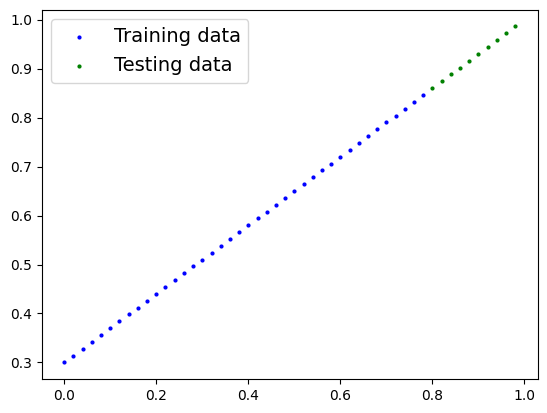

In [ ]:
plot_predictions();

In [ ]:
## Build Linear Regression Model Class

class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()

    # initialize model parameters
    self.weights = nn.Parameter(torch.randn(1, # start with a random weight and try to adjust it to the ideal weight
                                            requires_grad=True, # can be updated with grandient decent
                                            dtype=torch.float))

    self.bias = nn.Parameter(torch.rand(1,# start with a random bias and try to adjust it to the ideal bias
                                        requires_grad=True,
                                        dtype=float))

  # forward method to define the computation of the model
  # this method always gets called when an instance of the class is called
  # and will override the default method
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias




In [ ]:
# Inspect the model

# Create random seed
torch.manual_seed(42)

# create an instance of the model
model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1236], dtype=torch.float64, requires_grad=True)]

In [ ]:
# list named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])),
             ('bias', tensor([0.1236], dtype=torch.float64))])

In [ ]:
weight, bias


(0.7, 0.3)

In [ ]:
# predict y_test based on X_test with current data
with torch.inference_mode():

  # pass the model test data and save the output
  y_preds = model_0(X_test)

# print the output
y_preds

tensor([[0.3929],
        [0.3997],
        [0.4064],
        [0.4131],
        [0.4199],
        [0.4266],
        [0.4333],
        [0.4401],
        [0.4468],
        [0.4535]], dtype=torch.float64)

In [ ]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

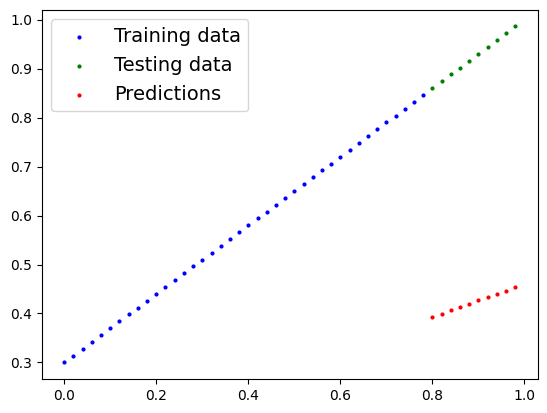

In [ ]:
# plot the predictions from the untrained model
plot_predictions(predictions=y_preds)

## Train the model

Things needed:
* **Loss Function** - measure of how wrong the model is, lower is better
* **Optimizer** takes loss into account and adjusts the model's params
* Training loop
* Testing loop

In [ ]:
# set up loss function
loss_fn = nn.L1Loss()

# set up an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) # learning rate. small value will adjust the param in a small step

### Training loop
0. loop through data
1. forward pass (moove data through the `forward()` functions)
2. Calculate lost (compare forward pass prediction to ground truth labels)
3. optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the params of the model with respect ot the loss
5. Optimizer step = use the optimizer ot adjust the model's params and try to improve the loss (**gradient descent**)

In [ ]:
torch.manual_seed(42)

# epoch == loop through the data
epochs = 200

# track different experiments to compare models
epoch_count = []
loss_values = []
test_loss_values = []

# 0. loop through data
for epoch in range(epochs):

  ################
  ### Training ###
  ################

  # set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate Loss
  loss = loss_fn(y_pred, y_train)

  # 3. Zero the gradients of the optimizer (they accumulate by default)
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss iwth repsect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will accumulate through the loop. this will need to be set to zero step three above

  ###############
  ### Testing ###
  ###############

  # turns off different settings we don't need in the model during evanualtion and testing
  model_0.eval()

  # turns off gradient tracking and a couple of things behind the scenes
  with torch.inference_mode():
    # 1. Forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)

    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    # 3.

    print(model_0.state_dict())

Epoch: 0 | Loss: 0.3181046841300179 | Test loss: 0.4862885119004262
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1336], dtype=torch.float64))])
Epoch: 10 | Loss: 0.20289471868724487 | Test loss: 0.3515785874409687
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2336], dtype=torch.float64))])
Epoch: 20 | Loss: 0.09230161711291159 | Test loss: 0.2209487388415347
OrderedDict([('weights', tensor([0.4185])), ('bias', tensor([0.3296], dtype=torch.float64))])
Epoch: 30 | Loss: 0.05343686922504778 | Test loss: 0.1459185384793292
OrderedDict([('weights', tensor([0.4517])), ('bias', tensor([0.3751], dtype=torch.float64))])
Epoch: 40 | Loss: 0.04533072821377819 | Test loss: 0.1135763742012987
OrderedDict([('weights', tensor([0.4757])), ('bias', tensor([0.3861], dtype=torch.float64))])
Epoch: 50 | Loss: 0.041489466948145565 | Test loss: 0.0991663576645861
OrderedDict([('weights', tensor([0.4947])), ('bias', tensor([0.3836], dtype=torch.float64))])
Epoch: 60 | Loss:

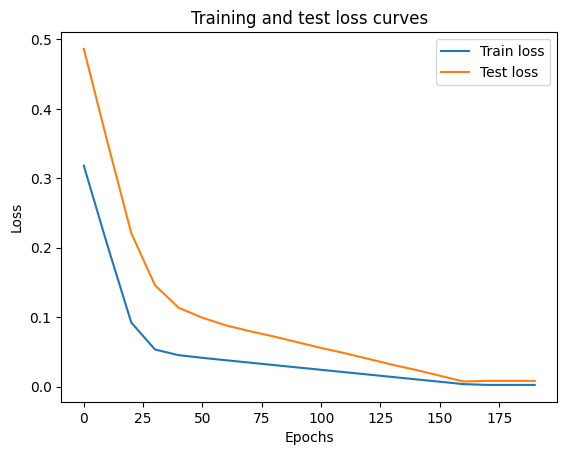

In [ ]:
import numpy as np

# plot the loss curves

# note: plt uses numpy. need to convert the `loss_values` from tensor to numpay array and run on the cpu
plt.plot(epoch_count, np.array(torch.tensor(loss_values).cpu().numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6947])),
             ('bias', tensor([0.2996], dtype=torch.float64))])

In [ ]:
weight, bias

(0.7, 0.3)

In [ ]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

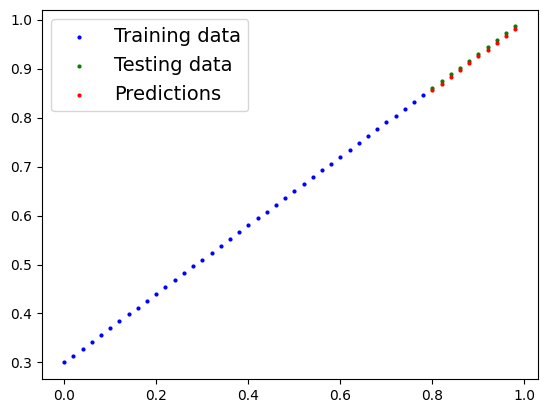

In [ ]:
plot_predictions(predictions=y_preds_new)

It's getting closer! 👆

## Saving a model in PyTorch

### Three ways
1. `torch.save()` - saves the model object in Python pickle
2. `torch.load()` - loads a saved model object
3. `torch.nn.Module.load_state_dict()` - loads the model's saved dictionary

In [ ]:
# save the model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model name to save
MODEL_NAME = "01_pytorch_workflow_model_01.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_01.pth


In [ ]:
ls -alh models

total 12K
drwxr-xr-x 2 root root 4.0K Mar 14 11:00 ./
drwxr-xr-x 1 root root 4.0K Mar 14 11:00 ../
-rw-r--r-- 1 root root 1.8K Mar 14 11:00 01_pytorch_workflow_model_01.pth


## Loading the model

Loading a model is initializing a new model class and loadin gin the `.state_dict()`


In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6947])),
             ('bias', tensor([0.2996], dtype=torch.float64))])

In [ ]:
# init new instance
loaded_model_0 = LinearRegressionModel()

# load state dict
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6947])),
             ('bias', tensor([0.2996], dtype=torch.float64))])

In [ ]:
# make predictions with trained model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8553],
        [0.8692],
        [0.8831],
        [0.8970],
        [0.9109],
        [0.9248],
        [0.9387],
        [0.9526],
        [0.9665],
        [0.9803]], dtype=torch.float64)

In [ ]:
# make predictions oritinal model
model_0.eval()
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.8553],
        [0.8692],
        [0.8831],
        [0.8970],
        [0.9109],
        [0.9248],
        [0.9387],
        [0.9526],
        [0.9665],
        [0.9803]], dtype=torch.float64)

In [ ]:
# compare loaded model preds with original preds
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

In [ ]:
# create a new model using layer for params instead of creating them manually
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # use nn.Linear() for creating model params, using linear transform
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      return self.linear_layer(x)


torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))